# Hypothesis Testing with Insurance Data (Kaggle)
- Jacob Lloyd
- Data taken from [Kaggle](https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset)

# Scope of Notebook

We have been asked to use our hypothesis testing skills to answer the following questions:
- Q1 Do smokers have higher insurance charges that non-smokers?
- Q2 Are men more likely to smoke than women?
- Q3 Do different regions have different charges, on average?

For each question I will:
- State Null and Alternate Hypothesis
- Select correct test according to the data type and number of samples
- Test the assumptions of your selected test
- Execute the selected test, or the alternate test if assumptions are not met
- Interpret p-value and reject/fail to reject hypothesis
- Show a supporting visualization that helps display the result

I will be interpreting "significance" using an alpha of 0.05.

In [1]:
alpha = 0.05

# Imports and Data Exploration

In [2]:
# General imports
import numpy as np
import pandas as pd

# Graphs
import seaborn as sns
import matplotlib.pyplot as plt

# Other
import scipy.stats as stats

In [3]:
df = pd.read_csv('Data/insurance - insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Let's view men vs women counts

In [4]:
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

We know there is not a significant difference in males vs females.

# Higher Insurance: Smokers vs Non-Smokers

Do smokers have higher insurance charges than non-smokers?

Null Hypothesis: There is no difference in insurance costs between smokers and non-smokers.

Alternative Hypothesis: There is a significant difference in insurance costs between smokers and non smokers. 

In [5]:
# create a smoker and non-smoker df, our hypothesis only requires 2 columns
smoker_df = df.loc[df['smoker'] == 'yes'][['smoker', 'charges']]
nonsmoker_df = df.loc[df['smoker'] == 'no'][['smoker', 'charges']]
display(smoker_df.head(2))
display(nonsmoker_df.head(2))

,smoker,charges
0,yes,16884.9240
11,yes,27808.7251


,smoker,charges
1,no,1725.5523
2,no,4449.4620


Since the datatype is numeric we will use the T-Test.

Assumptions:
 - No Significant Outliers
 - Normality
 - Equal Variance

## Testing Outliers Assumption

In [6]:
smoker_out = np.abs(stats.zscore(smoker_df['charges'])) > 3
nonsmoker_out = np.abs(stats.zscore(nonsmoker_df['charges'])) > 3
print(f"The Smoker group had {smoker_out.sum()} outliers out of {len(smoker_df)} entries.")
print(f"The NonSmoker group had {nonsmoker_out.sum()} outliers out of {len(nonsmoker_df)} entries.")

The Smoker group had 0 outliers out of 274 entries.
The NonSmoker group had 24 outliers out of 1064 entries.


Remove nonsmoker outliers

In [7]:
nonsmoker_df = nonsmoker_df.loc[~nonsmoker_out]
# expecting 1040 entries now
print(f"The NonSmoker group has {len(nonsmoker_df)} entries.")

The NonSmoker group has 1040 entries.


## Testing Normality Assumption

In [8]:
# create a function to test the normality
def test_normality(data):
    _, pval = stats.normaltest(data)
    print(f"P Value: {pval}")
    if pval > alpha:
        print(f"With a P Value of {pval} there is no statistical difference between our distribution and a normal distribution.")
    else:
        print(f"With an P Value of {pval} there is a statistical difference between our distribution and a normal distribution.")

In [9]:
test_normality(smoker_df['charges'])

P Value: 5.564930630036463e-14
With an P Value of 5.564930630036463e-14 there is a statistical difference between our distribution and a normal distribution.


In [10]:
test_normality(nonsmoker_df['charges'])

P Value: 2.6945416315543976e-36
With an P Value of 2.6945416315543976e-36 there is a statistical difference between our distribution and a normal distribution.


In [11]:
print(f"The Smoker group has {len(smoker_df)} entries.")
print(f"The NonSmoker group has {len(nonsmoker_df)} entries.")

The Smoker group has 274 entries.
The NonSmoker group has 1040 entries.


Our groups are large enough to disregard the assumption for normality.

## Testing Equal Variance Assumption

In [12]:
def test_variance(data1, data2):
    # use _ since var isn't used
    _, pval = stats.levene(data1, data2)
    print(f"P Value: {pval}")
    if pval > alpha:
        print(f"With a P Value of {pval} we have equal variance in the populations.")
    else:
        print(f"With a P Value of {pval} there is not equal variance in the populations.")

In [13]:
test_variance(smoker_df['charges'], nonsmoker_df['charges'])

P Value: 2.4247238784347824e-97
With a P Value of 2.4247238784347824e-97 there is not equal variance in the populations.


Due to unequal variances, Welch's T-Test must be used.

## Executing Test

In [14]:
_, pval = stats.ttest_ind(smoker_df['charges'], nonsmoker_df['charges'], equal_var = False)
print(f"There is a P Value of {pval}.")

There is a P Value of 2.5753226625873578e-104.


The null hypothesis is rejected and the alternative is supported. There is a significant difference in insurance cost between smokers and non-smokers.

## Visualization for Test

<AxesSubplot:xlabel='smoker', ylabel='charges'>

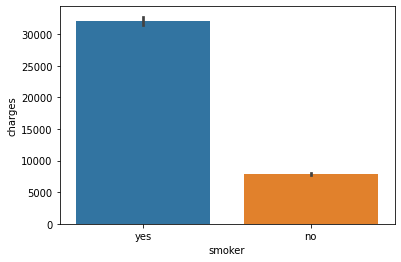

In [15]:
sns.barplot(data = pd.concat([smoker_df, nonsmoker_df], axis = 0), x = 'smoker', y = 'charges', ci = 68)

# More Likely To Smoke: Men vs Women
Are men more likely to smoke than women?

Null Hypothesis: There is no significant increase in men vs women smoking.

Alternative Hypothesis: There is a signficant increase in men vs women smoking. 

In [16]:
# create a male and female df, hpyothesis only requires 2 columns
male_df = df.loc[df['sex'] == 'male'][['sex', 'smoker']]
female_df = df.loc[df['sex'] == 'female'][['sex', 'smoker']]
display(male_df.head(3))
display(female_df.head(3))

,sex,smoker
1,male,no
2,male,no
3,male,no


,sex,smoker
0,female,yes
5,female,no
6,female,no


We will use the Chi-Square test. Since there are two categorical vairables and the outcomes are independent, our assumptions are met.

## Executing Test

In [17]:
_, pval, _, _ = stats.chi2_contingency(pd.crosstab(df['sex'], df['smoker']))
print(f"There is a P Value of {pval}.")

There is a P Value of 0.006548143503580696.


The null hypothesis is rejected. A signficiant statistical difference exists that men are more likely to smoke than women.

## Visualization for Test

<AxesSubplot:xlabel='sex', ylabel='count'>

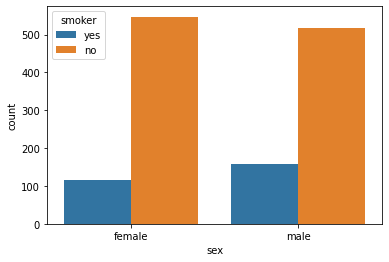

In [18]:
sns.countplot(data = df, x = 'sex', hue = 'smoker')

# Different Regions Charges
Do different regions have different charges, on average?

Null Hypothesis: Regions do not have a significant difference in charges.

Alternative Hypothesis: There is a significant difference in charges between different regions. 

In [19]:
df.head(15)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [20]:
# create a dictionary for each df, as opposed to 4 serparate df
region_dict = {}
for region in ['northeast', 'northwest', 'southeast', 'southwest']:
    region_df = df.loc[df['region'] == region]['charges']
    # print(region_df.head(3))
    region_dict[region] = region_df

In [21]:
# make sure dict saved correctly
for key, val in region_dict.items():
    print(f"Region: {key}, Charges Mean: {round(val.mean(), 2)}")

Region: northeast, Charges Mean: 13406.38
Region: northwest, Charges Mean: 12417.58
Region: southeast, Charges Mean: 14735.41
Region: southwest, Charges Mean: 12346.94


## Testing Outliers Assumption

In [22]:
for region, data in region_dict.items():
    outliers = np.abs(stats.zscore(data)) > 3
    print(f"{region} had {outliers.sum()} outliers removed.")
    region_dict[region] = data.loc[~outliers]

northeast had 4 outliers removed.
northwest had 7 outliers removed.
southeast had 2 outliers removed.
southwest had 8 outliers removed.


## Testing Normality Assumption

In [23]:
for region, data in region_dict.items():
    _, pval = stats.normaltest(data)
    if pval > alpha:
        print(f"With a P Value of {pval}, {region} has no statistical difference between our distribution and a normal distribution.")
    else:
        print(f"With a P Value of {pval}, {region} has a statistical difference between our distribution and a normal distribution.")

With a P Value of 3.5578767155624347e-17, northeast has a statistical difference between our distribution and a normal distribution.
With a P Value of 2.9405433782452325e-19, northwest has a statistical difference between our distribution and a normal distribution.
With a P Value of 1.9369900501741734e-13, southeast has a statistical difference between our distribution and a normal distribution.
With a P Value of 7.728611243124505e-22, southwest has a statistical difference between our distribution and a normal distribution.


## Equal Variance Assumption

In [24]:
_, pval = stats.levene(*region_dict.values())
if pval > alpha:
    print(f"With an alpha of {pval} we have equal variance in the populations.")
else:
    print(f"With an alpha of {pval} there is not equal variance in the populations.")

With an alpha of 3.2035503711783993e-06 there is not equal variance in the populations.


## Executing Test

Since we failed to prove our assumptions, we will need to use the kruskal test.

In [25]:
_, pval = stats.kruskal(*region_dict.values())
print(f"There is a P Value of {pval}.")

There is a P Value of 0.07468847911322242.


We failed to reject the null hypothesis. No statistical difference exists between regions for charges.

## Visualization for Test

<AxesSubplot:xlabel='region', ylabel='charges'>

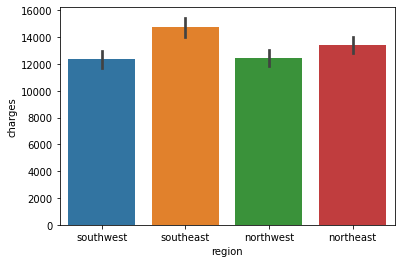

In [26]:
sns.barplot(data = df, x = 'region', y = 'charges', ci = 68)